In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
import warnings
warnings.filterwarnings("ignore")

import jax
import jax.random as jr

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

# Example – Surrogate for stochastic heat equation

## Deterministic, physical model

Consider the steady state heat equation on a heterogeneous rod (1D) with no heat sources:

$$
\frac{d}{dx}\left(c(x)\frac{d}{dx}u(x)\right) = 0,
$$

and boundary values:

$$
u(0) = 1\;\text{ and }\;u(1) = 0.
$$

The thermal conductivity $c$ lives in some function space $\mathcal{C},$ and the temperature $u$ lives in a function space $\mathcal{U}$.
Let $F: \mathcal{C} \rightarrow \mathcal{U}$ be the solver for the boundary value problem, i.e., $u = F(c)$.
Suppose we are uncertain about the thermal conductivity, $c(x)$, and we want to propagate this uncertainty to the temperature field, $u(x)$.

## Uncertain thermal conductivity

Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $c(x)$ that represents our uncertainty.
This requires assigning a probability measure on the function space $\mathcal{C}$.
Let's say the conductivity $c$ is given by

$$
c(x; \xi) = c_0(x) \exp\Big\{ g(x; \xi) \Big\},
$$

where $c_0$ is the "mean" thermal conductivity and $g$ follows a zero-mean Gaussian process, i.e.,

$$
\begin{align*}
g \sim \operatorname{GP}(0, k).
\end{align*}
$$

<!-- (The reason for the exponential is that $c(x; \xi)$ must be positive.)  -->
Finally, let $k$ be the squared-exponential kernel.
Let's implement the Karhunen-Loeve expansion of the random field $c$:

<!-- In particular, we want to build a surrogate for the stochastic heat equation solver. -->

<!-- For now, we will just give you a model.
We will model $c = c(x;\boldsymbol{\xi})$ as:
$$
c(x;\boldsymbol{\xi}) = c_0(x)\exp\{g(x;\boldsymbol{\xi})\},
$$
where $c_0(x)$ is a "mean" conductivity level and $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $c(x;\boldsymbol{\xi})$ must be positive.
We will assume that the random field ia a [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
This is a field that it is no-where continuous and it is actually a fractal (when you zoom in the spatial dimension, the field resembles itself at a larger scale).
The Karhunen-Loeve expansion of the field is:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^\infty\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are the eigenfunctions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.
For the record, this corresponds to a random field known as the 
Since, we cannot actually work with the infinite sums, let's truncate at $i=d$ and define:
$$
g_d(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x).
$$ -->


In [10]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import equinox as eqx
from tinygp import GaussianProcess, kernels, transforms
from jaxtyping import Array, Float

class KarhunenLoeveExpansion(eqx.Module):
    """
    The Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Parameters
    ----------
    gp : tinygp.GaussianProcess
        The Gaussian process to expand.
    wq : Float[Array, "n_q"]
        The quadrature weights.
    alpha : float
        The percentage of the energy of the field that you want to keep.
    """
    gp: GaussianProcess
    lambd: Float[Array, "n_xi"]
    v: Float[Array, "n_xi n_q"]
    wq: Float[Array, "n_q"]
    
    def __init__(self, gp, wq, alpha=0.9):
        # Get the covariance (evaluated at the quadrature points).
        # If our gp is conditioned on some observations, then this will be the posterior covariance.
        Kq = gp.covariance

        # Get the eigenvalues/eigenvectors of the discretized covariance function
        B = jnp.einsum('ij,j->ij', Kq, wq)
        lam, v = jax.scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam = lam.at[lam <= 0.].set(0.)

        # Keep only the eigenvalues that explain alpha% of the energy
        energy = jnp.cumsum(lam) / jnp.sum(lam)
        i_end = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        
        self.gp = gp
        self.lambd = lam
        self.v = v
        self.wq = wq
    
    @property
    def energy(self):
        """The energy captured by the truncated expansion."""
        return jnp.sum(self.lambd)
    
    @property
    def num_xi(self):
        """The number of terms kept in the truncated expansion."""
        return self.lambd.shape[0]
    
    def eval_phi(self, x):
        """Evaluate the eigenfunctions at x."""
        Kc = self.gp.kernel(x, self.gp.X)  # Evaluate the cross-covariance between the query points (x) and the quadrature points (self.gp.X)
        phi = jnp.einsum("i,ji,j,rj->ri", 1/self.lambd, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """Evaluate the expansion at x and xi."""
        phi = self.eval_phi(x)
        return vmap(self.gp.mean_function)(x) + jnp.dot(phi, xi*self.lambd**0.5)

def build_kle(
    k, 
    nq=100, 
    alpha=0.9, 
    Xq=None, 
    wq=None, 
    Xobs=None, 
    yobs=None, 
    *, 
    input_dim
):
    """Build the Karhunen-Loève expansion of a Gaussian process.
    
    Parameters
    ----------
    k : tinygp.kernels.Kernel
        The kernel of the Gaussian process.
    nq : int
        The number of quadrature points.
    alpha : float
        The percentage of the energy of the field that you want the expansion to capture.
        This determines the number of terms in the expansion.
    Xq : jnp.ndarray
        The quadrature points.
    wq : jnp.ndarray
        The quadrature weights
    Xobs : jnp.ndarray
        The observed points.
    yobs : jnp.ndarray
        The observed values.
    input_dim : int
        The dimension of the input space.
    
    Returns
    -------
    kle : KarhunenLoeveExpansion
        The Karhunen-Loève expansion of the Gaussian process.
    """
    # Generate quadrature points
    if Xq is None:
        if input_dim == 1:
            Xq = jnp.linspace(0, 1, nq)[:, None]
            wq = jnp.ones((nq,))/nq
        elif input_dim == 2:
            nq = int(jnp.sqrt(nq))
            x = jnp.linspace(0, 1, nq)
            X1, X2 = jnp.meshgrid(x, x)
            Xq = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
            wq = jnp.ones((nq**2,))/nq**2
        else:
            raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
    
    # Build the Gaussian process
    if Xobs is not None:
        _, gp = GaussianProcess(k, Xobs, diag=1e-6).condition(y=yobs, X_test=Xq)
    else:
        gp = GaussianProcess(k, Xq, diag=1e-6)
    
    # Build the KLE
    return KarhunenLoeveExpansion(gp, wq, alpha)

In [4]:
k = 0.5*kernels.ExpSquared(scale=0.1)
kle = build_kle(k, nq=1000, alpha=0.95, input_dim=1)

def c(x, xi):
    """Compute the random thermal conductivity field for a given xi."""
    return jnp.exp(kle(x, xi))

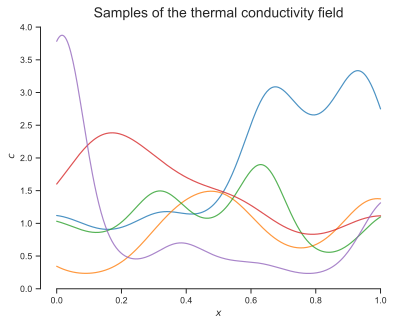

In [ ]:
x = jnp.linspace(0, 1, 300)[:, None]
fig, ax = plt.subplots()
ax.set_title("Samples of the thermal conductivity field", fontsize=14)
for i in range(5):
    key, key_xi = jr.split(key)
    xi = jr.normal(key_xi, shape=(kle.num_xi,))
    f = c(x, xi)
    ax.plot(x, f, alpha=0.8)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c$")
sns.despine(trim=True);

## Reduce dimensionality of the stochastic model input

Suppose we are interested the temperature at the *center* of the rod, i.e., at $x = 0.5$.
Our model is therefore 

$$
u_{0.5} \equiv u_{0.5}(c) \equiv \underbrace{F(c)}_{= u}(0.5).
$$

The quantity of interest $u_{0.5}$ is stochastic because the thermal conductivity $c$ is stochastic.
To quantify uncertainty in $u_{0.5}$, replace $c$ with its truncated Karhunen-Loeve expansion $\hat{c}$:

$$
u_{0.5} \approx \hat{u}_{0.5}(\xi) \equiv F\Big(\hat{c}(\xi)\Big)(0.5).
$$

The infinite-dimensional uncertainty propagation problem has now been reduced to a finite one!
This is extremely useful.
For example, to sample $u_{0.5}$, we can simply follow these steps:
1. Sample $\xi \sim \mathcal{N}(0, I)$.
2. Evaluate $\hat{c}(\xi)$, the truncated Karhunen-Loeve expansion at $\xi$. The result is a sample of the conductivity field $c.$
3. Numerically solve the deterministic heat equation with $c$ for time $t=0.5$. The result is a sample of $u_{0.5}$.

Let's visualize a few samples of the entire temperature field $u(x)$. 

First, we need the solver $F$. We will use the [finite volume method](https://en.wikipedia.org/wiki/Finite_volume_method) as implemented in [FiPy](http://www.ctcms.nist.gov/fipy). Here is the solver:

In [6]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    g           -    The random field the describes the conductivity.
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, c, nx=100, value_left=1., value_right=0.):
        self.c = c
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        c_val = self.c(x[:, None], xi)
        self.C.setValue(c_val)
        self.eq.solve(var=self.phi)
        return x, self.phi.faceValue()

In [7]:
solver = SteadyStateHeat1DSolver(c=c, nx=500)

Now let's (approximately) sample $u$:

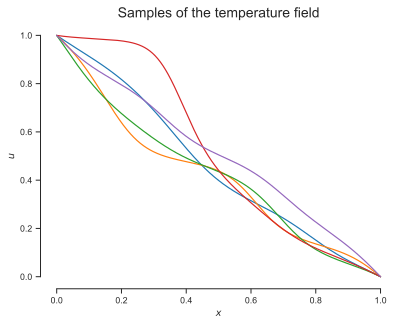

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Samples of the temperature field", fontsize=14)
for i in range(5):
    key, key_xi = jr.split(key)
    xi = jr.normal(key_xi, shape=(kle.num_xi,))
    x, y = solver(xi)
    ax.plot(x, y)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")
sns.despine(trim=True);

## Surrogate for the stochastic model

Uncertainty propagation can still be slow, depending on how fast the solver $F$ is.
To speed it up, we will build a Gaussian process surrogate for $\hat{u}_{0.5}(\xi)$. This GP will take the coefficients $\xi$ as inputs and will output the quantity of interest $\hat{u}_{0.5}$.

First, we need some training data. 
We'll generate data by solving the governing heat equation for many different samples of thermal conductivity.

In [9]:
xis = []
u05s = []
for i in range(200):
    key, key_xi = jr.split(key)
    xi = jr.normal(key_xi, shape=(kle.num_xi,))
    x, y = solver(xi)
    xis.append(xi)
    u05s.append(y[x==0.5][0])
xis = jnp.stack(xis, axis=0)
u05s = jnp.array(u05s)

from sklearn.model_selection import train_test_split
key, key_split = jr.split(key)
xi_train, xi_test, u05_train, u05_test = train_test_split(xis, u05s, test_size=0.2, random_state=int(jr.randint(key_split, shape=(), minval=0, maxval=1e6)))

Now let's train the surrogate:

In [12]:
from jax import lax, value_and_grad
import optax
from functools import partial

def build_gp(params, X):
    """Build a Gaussian process with RBF kernel.
    
    Parameters
    ----------
    params : dict
        Hyperparameters of the GP.
    X : ndarray
        Training data input locations.
    
    Returns
    -------
    GaussianProcess
        The GP.
    """
    amplitude = jnp.exp(params['log_amplitude'])
    lengthscale = jnp.exp(params['log_lengthscale'])
    k = amplitude*transforms.Linear(1/lengthscale, kernels.ExpSquared())
    return GaussianProcess(kernel=k, X=X, diag=1e-6)

def loss(params, X, y):
    """Negative marginal log likelihood of the GP."""
    gp = build_gp(params, X)
    return -gp.log_probability(y)

@eqx.filter_jit
def train_step_adam(carry, _, X, y, optim, batch_size):
    params, opt_state, key = carry
    key, subkey = jr.split(key)
    idx = jr.randint(subkey, (batch_size,), 0, X.shape[0])
    value, grads = value_and_grad(loss)(params, X[idx], y[idx])
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, key), value

def train_gp(init_params, X, y, num_iters, learning_rate, batch_size, key):
    """Optimize the hyperparameters (xi) of a GP using the Adam optimizer.
    
    Parameters
    ----------
    init_params : dict
        Initial values of the hyperparameters.
    X, y: ndarray
        Training data.
    num_iters : int
        Number of optimization steps.
    learning_rate : float
        Learning rate for the optimizer.
    
    Returns
    -------
    dict
        The optimized hyperparameters.
    ndarray
        The loss values at each iteration.
    """
    
    # Initialize the optimizer
    optim = optax.adam(learning_rate)

    # Initialize the optimizer state
    init_carry = (init_params, optim.init(init_params), key)

    # Do optimization
    train_step = partial(train_step_adam, X=X, y=y, optim=optim, batch_size=batch_size)
    carry, losses = lax.scan(train_step, init_carry, None, num_iters)

    return carry[0], losses  # (optimized params, loss values)

In [19]:
init_params = {
    'log_amplitude': 1.0, 
    'log_lengthscale': -jnp.ones(xis.shape[1]),  # Different lengthscale for each input dimension
}
key, subkey = jr.split(key)
optimized_params, _ = train_gp(
    init_params, 
    X=xi_train, 
    y=u05_train, 
    num_iters=1000, 
    learning_rate=1e-2,
    batch_size=100,
    key=subkey
)

Let's evaluate the fit on some test points:

In [20]:
optimized_gp = build_gp(optimized_params, xi_train)
u05_pred_test_mean, u05_pred_test_var = optimized_gp.predict(y=u05_train, X_test=xi_test, return_var=True)

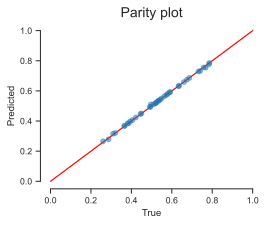

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title("Parity plot", fontsize=14)
ax.errorbar(u05_test, u05_pred_test_mean, yerr=jnp.sqrt(u05_pred_test_var), fmt='o', label="Predictions", alpha=0.5)
ax.plot([0, 1], [0, 1], 'r-', label="Ideal")
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
sns.despine(trim=True);

The fit looks good.

## Uncertainty propagation

We can now use the surrogate to do uncertainty quantification tasks for very cheap!

For example, let's visualize the distribution of $u_{0.5}$:

In [22]:
xi = jr.normal(key, shape=(2000, kle.num_xi,))
u05 = optimized_gp.predict(y=u05_train, X_test=xi)

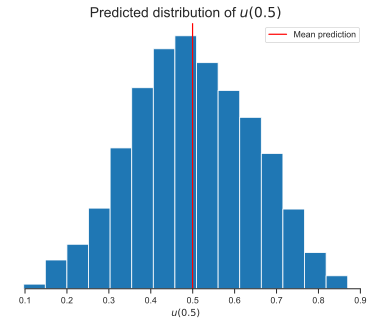

In [27]:
fig, ax = plt.subplots()
ax.hist(u05, bins=15, density=True)
ax.axvline(u05.mean(), color='r', label="Mean prediction")
ax.set_xlabel(r"$u(0.5)$")
ax.set_title("Predicted distribution of $u(0.5)$", fontsize=14)
ax.legend()
ax.set_yticks([])
sns.despine(trim=True, left=True);